In [49]:
import pandas as pd
import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

import re
import string
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('omw-1.4',quiet=True)
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import  LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity as cs

from wordcloud import WordCloud

import warnings

In [3]:
# !pip install --upgrade numpy==1.23.5
import numpy as np
print(np.__version__)

1.23.5


In [4]:
default_stemmer = PorterStemmer()
default_stopwords = stopwords.words('english')
default_stopwords = default_stopwords + ['said', 'would','even','according','could','year',
                                         'years','also','new','people','old,''one','two','time',
                                         'first','last','say','make','best','get','three','make',
                                         'year old','told','made','like','take','many','set','number',
                                         'month','week','well','back']
shortword = re.compile(r'\W*\b\w{1,4}\b\d')
BAD_SYMBOLS_RE = re.compile("[^a-zA-Z,\d]")
REPLACE_IP_ADDRESS = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
def clean_text(text, ):

    def tokenize_text(text):
        return [w for s in sent_tokenize(text) for w in word_tokenize(s) if len(w)>=3]

    def preprocessing_text(text):
        text = text.lower()
        text=text.replace('\n',' ').replace('\xa0',' ').replace('-',' ').replace('ó','o').replace('ğ','g').replace('á','a').replace("'"," ")
        text=re.sub(r'\d+','', text)
        text=re.sub(r'http\S+', '', text)
        text=BAD_SYMBOLS_RE.sub(' ', text)
        text=REPLACE_IP_ADDRESS.sub('', text)
        text=REPLACE_BY_SPACE_RE.sub(' ', text)
        text=' '.join(word for word in text.split() if len(word)>3)
        
        return text

    def remove_special_characters(text, characters=string.punctuation.replace('-', '')):
        tokens = tokenize_text(text)
        pattern = re.compile('[{}]'.format(re.escape(characters + '0123456789')))
        return ' '.join(filter(None, [pattern.sub('', t) for t in tokens]))

    def stem_text(text, stemmer=default_stemmer):
        tokens = tokenize_text(text)
        return ' '.join([stemmer.stem(t) for t in tokens])

    def lemm_text(text, lemm=WordNetLemmatizer()):
        tokens = tokenize_text(text)
        return ' '.join([lemm.lemmatize(t) for t in tokens])

    def remove_stopwords(text, stop_words=default_stopwords):
        tokens = [w for w in tokenize_text(text) if w not in stop_words]
        return ' '.join(tokens)
    
    text = text.strip(' ') # strip whitespaces
    text = text.lower() # lowercase
    #text = stem_text(text) # stemming
    text=preprocessing_text(text)
    text = remove_special_characters(text) # remove punctuation and symbols
    text = lemm_text(text) # lemmatizer
    text = remove_stopwords(text) # remove stopwords

    return text

In [5]:
df = pd.read_csv('MN-DS-news-classification.csv')

In [6]:
df = df[df['category_level_1'].isin(['sport', 'science and technology', 'economy, business and finance', 'arts, culture, entertainment and media','politics', ])]

In [7]:
df['text']= df[['title', 'content']].apply(lambda x: ' . '.join(x.astype(str)),axis=1)

In [50]:
df['text'] = df['text'].apply(clean_text)

In [9]:
def encode_labels(y):
    le = LabelEncoder()
    return le.fit_transform(y)

In [10]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel

In [11]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
layer = TFDistilBertModel.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertModel: ['pre_classifier', 'classifier', 'dropout_19']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [12]:
def regular_encode(texts, tokenizer,  maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        truncation=True,
        return_attention_mask=False, 
        return_token_type_ids=False,
        padding=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [13]:
# def build_model(transformer, y_shape, loss='categorical_crossentropy', max_len=512):
#     input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
#     sequence_output = transformer(input_word_ids)[0]
#     cls_token = sequence_output[:, 0, :]
#     #adding dropout layer
    
#     x = tf.keras.layers.Dropout(0.3)(cls_token)

#     #using a dense layer of category size neurons. 
#     out = tf.keras.layers.Dense(y_shape, activation='sigmoid')(x)
#     model = tf.keras.Model(inputs=input_word_ids, outputs=out)

#     #using categorical crossentropy as the loss as it is a multi-class classification problem
#     model.compile(tf.keras.optimizers.Adam(learning_rate=5e-5), loss=loss, metrics=['accuracy'])
#     return model

In [14]:
def build_model(transformer, y_shape, loss='categorical_crossentropy', max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    
    # Adding dropout layer after the transformer output
    x = tf.keras.layers.Dropout(0.5)(cls_token)
    
    # Adding additional dense layers
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    out = tf.keras.layers.Dense(y_shape, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    
    # Compile with a lower learning rate
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss=loss, metrics=['accuracy'])
    
    return model


With CrossValidation

In [15]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import tensorflow as tf

def train_dist_bert_with_cv(X, y, transformer, num_folds=5):
    y_lr = encode_labels(y)
    y_cat = tf.keras.utils.to_categorical(y_lr, dtype='int32')
    
    # Initialize StratifiedKFold with the number of folds
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    fold_no = 1
    accuracies = []
    losses = []
    
    for train_index, val_index in skf.split(X, y_lr):
        print(f"Training fold {fold_no}/{num_folds}...")
        
        # Split the data
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y_cat[train_index], y_cat[val_index]

        # Build a new model for each fold
        model = build_model(transformer, y_shape=y_cat.shape[1], loss='categorical_crossentropy')

        # Create the datasets
        BATCH_SIZE = 32
        AUTO = tf.data.experimental.AUTOTUNE
        
        train_dataset = (
            tf.data.Dataset
            .from_tensor_slices((X_train, y_train))
            .shuffle(2048)
            .batch(BATCH_SIZE)
            .prefetch(AUTO)
        )
        
        val_dataset = (
            tf.data.Dataset
            .from_tensor_slices((X_val, y_val))
            .batch(BATCH_SIZE)
        )
        
        # Train the model
        train_history = model.fit(
            train_dataset,
            epochs=10,
            validation_data=val_dataset,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            ]
        )
        
        # Evaluate the model on validation data
        val_loss, val_accuracy = model.evaluate(val_dataset)
        accuracies.append(val_accuracy)
        losses.append(val_loss)
        
        print(f"Fold {fold_no}: Validation accuracy: {val_accuracy}, Validation loss: {val_loss}")
        
        fold_no += 1
    
    # Average performance across all folds
    avg_accuracy = np.mean(accuracies)
    avg_loss = np.mean(losses)
    
    print(f"\nAverage Validation Accuracy over {num_folds} folds: {avg_accuracy}")
    print(f"Average Validation Loss over {num_folds} folds: {avg_loss}")
    
    return model, avg_accuracy, avg_loss

# Example of how you would call the function
# X = your input data
# y = your labels
# transformer = your pretrained transformer model

# trained_model, avg_acc, avg_loss = train_dist_bert_with_cv(X, y, transformer)


In [44]:
def train_dist_bert(X, y, model_save_path):
    
    y_lr = encode_labels(y)

    #converting the categories into one hot vectors using tf.keras.utils.to_categorical
    y_cat = tf.keras.utils.to_categorical(y_lr, dtype = 'int32')

    X_train, X_test, y_train, y_test = train_test_split(X, y_cat, random_state = 42, test_size = 0.2)
    
    #building the model
    model = build_model(layer, max_len=80, y_shape=y_cat.shape[1])
    
    #creating the training and testing dataset.
    BATCH_SIZE = 32
    AUTO = tf.data.experimental.AUTOTUNE 
    train_dataset = (
        tf.data.Dataset
        .from_tensor_slices((X_train, y_train))
        .repeat()
        .shuffle(2048)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )
    test_dataset = (
        tf.data.Dataset
        .from_tensor_slices(X_test)
        .batch(BATCH_SIZE)
    )
    
    #training for 10 epochs
    n_steps = X_train.shape[0] // BATCH_SIZE
    train_history = model.fit(
        train_dataset,
        steps_per_epoch=n_steps,
        epochs=10,
        validation_data=(X_test, y_test)
    )

    # Plotting the training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(train_history.history['accuracy'], label='Training Accuracy', color='tab:green')
    plt.plot(train_history.history['val_accuracy'], label='Validation Accuracy', color='tab:olive', linestyle='--')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_history.history['loss'], label='Training Loss', color='tab:blue')
    plt.plot(train_history.history['val_loss'], label='Validation Loss', color='tab:cyan', linestyle='--')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    #making predictions
    preds = model.predict(test_dataset,verbose = 1)
    #converting the one hot vector output to a linear numpy array.
    pred_classes = np.argmax(preds, axis = 1)
    
    print('Precision is {}'.format(precision_score(np.argmax(y_test, axis=1), pred_classes, average='macro')))
    print('Recall is {}'.format(recall_score(np.argmax(y_test, axis=1), pred_classes, average='macro')))
    print('F1:', f1_score(np.argmax(y_test, axis=1), pred_classes, average='macro'))

    model.save(model_save_path)

In [17]:
X_encoded = regular_encode(df['text'].astype('str'), tokenizer, maxlen=80)

Epoch 1/10
82/82 [==============================] - 32s 238ms/step - loss: 2.2485 - accuracy: 0.2104 - val_loss: 1.6581 - val_accuracy: 0.3218
Epoch 2/10
82/82 [==============================] - 17s 211ms/step - loss: 2.1744 - accuracy: 0.2298 - val_loss: 1.5610 - val_accuracy: 0.3595
Epoch 3/10
82/82 [==============================] - 17s 206ms/step - loss: 1.9762 - accuracy: 0.2893 - val_loss: 1.3561 - val_accuracy: 0.4773
Epoch 4/10
82/82 [==============================] - 17s 206ms/step - loss: 1.7492 - accuracy: 0.3537 - val_loss: 1.0964 - val_accuracy: 0.6269
Epoch 5/10
82/82 [==============================] - 17s 210ms/step - loss: 1.4633 - accuracy: 0.4581 - val_loss: 0.9223 - val_accuracy: 0.7100
Epoch 6/10
82/82 [==============================] - 17s 206ms/step - loss: 1.2625 - accuracy: 0.5503 - val_loss: 0.8092 - val_accuracy: 0.7341
Epoch 7/10
82/82 [==============================] - 17s 208ms/step - loss: 1.1442 - accuracy: 0.6033 - val_loss: 0.7384 - val_accuracy: 0.7613

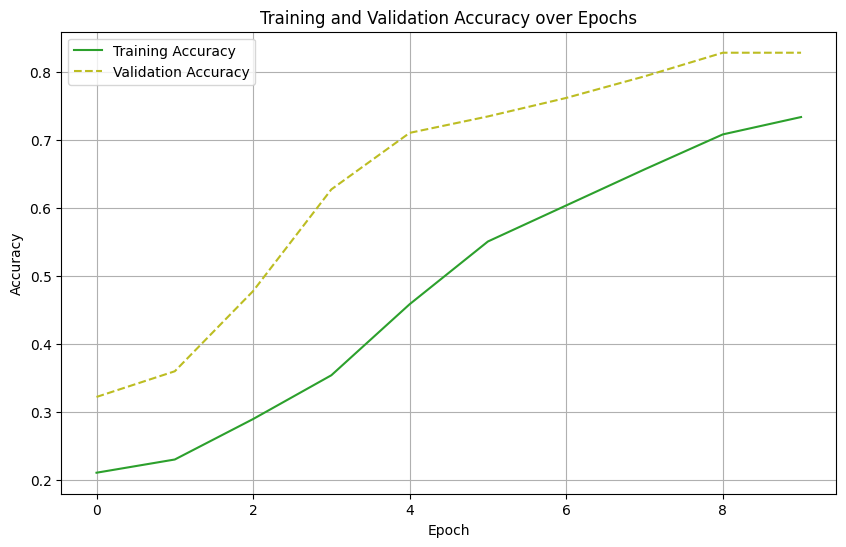

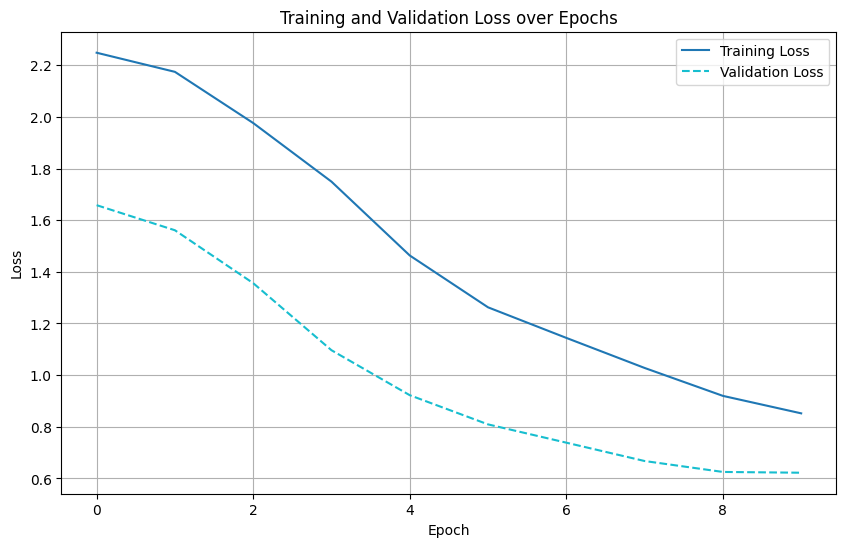

21/21 [==============================] - 4s 74ms/step
Precision is 0.8424510481885875
Recall is 0.7704638101293468
F1: 0.786997989214915


In [18]:
train_dist_bert(X_encoded, df['category_level_1'], 'bjk/model_category_level_1.h5')


In [19]:
# Model_trained = train_dist_bert_with_cv(X_encoded, df['category_level_1'],layer)
pint()s

SyntaxError: invalid syntax (2196590556.py, line 2)

In [20]:
import os
import numpy as np
import tensorflow as tf
from transformers import TFDistilBertModel, DistilBertTokenizer

# ล้างหน่วยความจำ
tf.keras.backend.clear_session()

# ใช้ CPU แทน GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# ใช้ eager execution
tf.config.run_functions_eagerly(True)

# โหลด tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# โหลดโมเดล
model_category_level_1 = tf.keras.models.load_model(
    'bjk/model_category_level_1.h5',
    custom_objects={'TFDistilBertModel': TFDistilBertModel}
)

In [34]:
new_texts = [
    "Macau: Thailand's Rattanon Wannasrichan kept up his unrelenting pace at the Macao Open on Friday by adding a second-round four-under-par 66 to his opening 61 to keep the lead. Rattanon is 13 under for the UScopy million tournament and has a two-shot lead over fellow Thai Gunn Charoenkul, who fired a 64. Suteepat Prateeptienchai made it a monopoly for Thailand so far after returning a 63 to sit third, a shot further back, at the par-70 Macau Golf & Country Club."
]

# กำหนด maxlen ตามที่ใช้ในขณะฝึกโมเดล
maxlen = 80

# ฟังก์ชันเข้ารหัสข้อความใหม่
def regular_encode(texts, tokenizer, maxlen=80):
    tokens = tokenizer(texts, padding='max_length', truncation=True, max_length=maxlen, return_tensors='tf')
    return tokens['input_ids']

# เข้ารหัสข้อความใหม่
X_new_encoded = regular_encode(new_texts, tokenizer, maxlen=maxlen)


In [35]:
def findCategory2(find):
  grouped_counts = df.groupby(['category_level_1'])['data_id'].agg('count')
  unique_categories = grouped_counts.index.tolist()
  if len(unique_categories) >= find:
      category = unique_categories[find]  # Index 26 corresponds to the 27th element
      print(f"Count for category '{category}'")
  else:
      print("There are fewer than ",find," unique categories in 'category_level_1'.")

In [36]:
print("Shape of X_new_encoded:", X_new_encoded.shape)

predictions_level_1 = model_category_level_1.predict(X_new_encoded)
# predictions_level_2 = model_category_level_2.predict(X_new_encoded)

# แสดงผลการทำนาย
predicted_classes_level_1 = np.argmax(predictions_level_1, axis=1)
# predicted_classes_level_2 = np.argmax(predictions_level_2, axis=1)
print(predictions_level_1[0].sum())
print(predictions_level_1[0])
print(findCategory2(np.argmax(predictions_level_1[0])))
predictions_level_1[0][np.argmax(predictions_level_1, axis=1)[0]] = 0
print(predictions_level_1[0][np.argmax(predictions_level_1, axis=1)[0]])
print(findCategory2(np.argmax(predictions_level_1[0])))
print(np.argmax(predictions_level_1, axis=1))

print("Predicted Classes for Category Level 1:", predicted_classes_level_1)
# print("Predicted Classes for Category Level 2:", predicted_classes_level_2)

Shape of X_new_encoded: (1, 80)


c:\Users\Jakkapan\anaconda3\envs\env\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 256ms/step
1.7898338
[0.55406845 0.14529273 0.17779246 0.16685729 0.7458229 ]
Count for category 'sport'
None
0.55406845
Count for category 'arts, culture, entertainment and media'
None
[0]
Predicted Classes for Category Level 1: [4]


In [23]:
df.groupby(['category_level_1'])['data_id'].agg('count')

category_level_1
arts, culture, entertainment and media    300
economy, business and finance             400
politics                                  900
science and technology                    800
sport                                     907
Name: data_id, dtype: int64

In [26]:
print(findCategory2(0))
print(findCategory2(2))

Count for category 'arts, culture, entertainment and media': 300
None
Count for category 'politics': 900
None


In [47]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [37]:
import tensorflow as tf 
print(tf.reduce_sum(tf.random.normal([1000, 1000])))

tf.Tensor(370.88947, shape=(), dtype=float32)


In [38]:
import tensorflow as tf

# ตรวจสอบว่า TensorFlow ใช้ GPU หรือ CPU
print("Num GPUs Available : ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available: ", len(gpus))
else:
    print("No GPUs available.")


Num GPUs Available :  1
GPUs Available:  1


In [43]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18212171224110990353
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3655335936
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10919744130481314056
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [1]:
import tensorflow as tf
import transformers

print("TensorFlow version:", tf.__version__)
print("Transformers version:", transformers.__version__)
print(tf.sysconfig.get_build_info()['cudnn_version'])

TensorFlow version: 2.10.0
Transformers version: 4.21.1
64_8
